### Detecção de anomalias para a feature "Quantidade de comprovantes por código da operação"

### Issue referente à feature

Issue: [#262](https://github.com/lappis-unb/salic-ml/issues/262)

#### Recarregar automaticamente os módulos

In [83]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Importing data

In [84]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats


from salicml.utils.dates import Dates
from salicml.utils.read_csv import read_csv
from salicml.utils.utils import debug

PROJECT_ROOT = os.path.abspath(os.path.join(os.pardir, os.pardir))
DATA_FOLDER = os.path.join(PROJECT_ROOT, 'data', 'raw')

#### PLANILHA ORCAMENTARIA

QUERY: /data/scripts/planilha_orcamentaria.sql


In [85]:
dt_comprovacao_name = 'planilha_comprovacao_667.csv'
usecols = ['idPlanilhaAprovacao', 'PRONAC', 'idComprovantePagamento', 'idSegmento']

dt_items = read_csv(dt_comprovacao_name, usecols=usecols)
display(dt_items.columns)
dt_items.head()

Index(['PRONAC', 'idPlanilhaAprovacao', 'idComprovantePagamento',
       'idSegmento'],
      dtype='object')

,PRONAC,idPlanilhaAprovacao,idComprovantePagamento,idSegmento
0,1012121,18552,4326,71
1,1012121,18553,4332,71
2,1012121,18554,4755,71
3,1012121,18555,4334,71
4,1012121,18556,4327,71


# Dividindo pronacs de treino e pronacs de teste

50/50

In [86]:
from sklearn.model_selection import train_test_split


all_pronacs = dt_items.PRONAC.unique()
pronacs_train, pronacs_test = train_test_split(all_pronacs, test_size=0.5)


dt_train = dt_items[dt_items['PRONAC'].isin(pronacs_train)]
dt_test = dt_items[dt_items['PRONAC'].isin(pronacs_test)]

In [87]:
print('pronacs_train = {}'.format(pronacs_train))
print('pronacs_test = {}'.format(pronacs_test))

assert (dt_train.shape[0] + dt_test.shape[0]) == dt_items.shape[0]

display(dt_train.head())
display(dt_test.head())

pronacs_train = [ 150705  175693  147357 ... 1410731  171180  153585]
pronacs_test = [ 135567  151091  139298 ...  124984 1412112  164666]


,PRONAC,idPlanilhaAprovacao,idComprovantePagamento,idSegmento
187,1011390,25392,180557,11
188,1011390,25397,182132,11
189,1011390,25397,182140,11
190,1011390,25397,182144,11
191,1011390,25397,182150,11


,PRONAC,idPlanilhaAprovacao,idComprovantePagamento,idSegmento
0,1012121,18552,4326,71
1,1012121,18553,4332,71
2,1012121,18554,4755,71
3,1012121,18555,4334,71
4,1012121,18556,4327,71


In [88]:
segment_projects = dt_train[['PRONAC', 'idSegmento', 'idComprovantePagamento']].groupby(['idSegmento', 'PRONAC']).nunique()
segment_projects.drop(columns=['PRONAC', 'idSegmento'], inplace=True)
segment_projects.rename(columns={'idComprovantePagamento': 'NumeroComprovantes'}, inplace=True)

display(segment_projects.head())

NumeroComprovantes
idSegmento PRONAC                    
11         113951                  71
           118216                  29
           118687                  71
           120953                  85
           121761                  51

### Plotando as distribuiçoes dos segmentos mais comuns

In [89]:
common_segments = segment_projects.groupby(['idSegmento']).count()
common_segments.rename(columns={'NumeroComprovantes': 'NumeroProjetos'}, inplace=True)
common_segments.sort_values(by=['NumeroProjetos'], ascending=False, inplace=True)
display(common_segments.head())

,NumeroProjetos
idSegmento,
11,324
33,211
12,149
32,135
4B,123


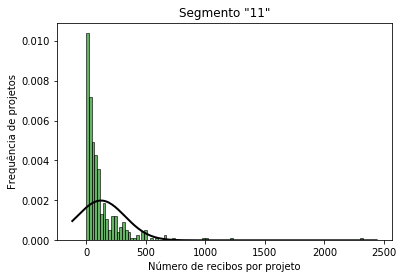

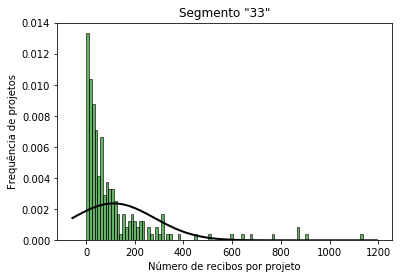

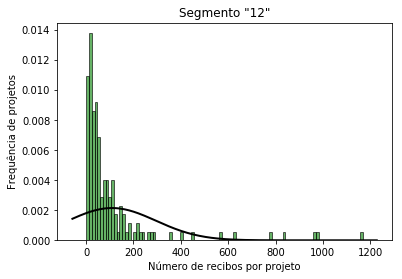

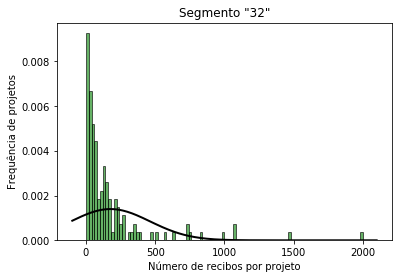

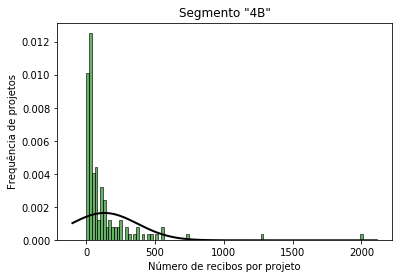

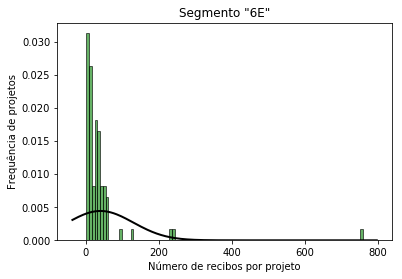

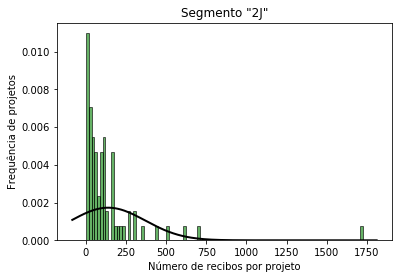

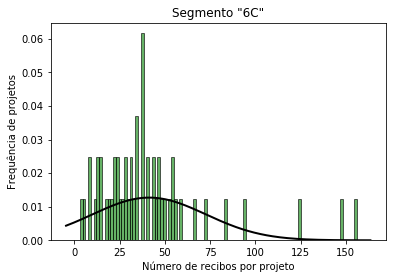

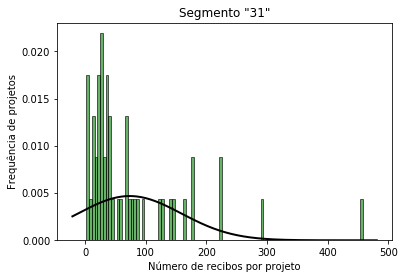

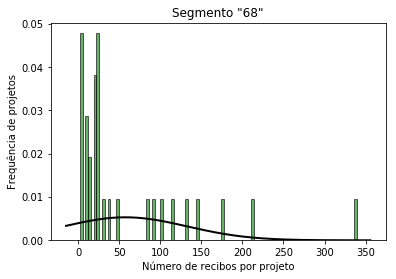

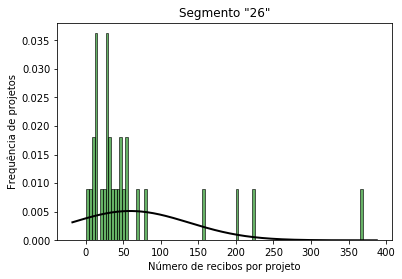

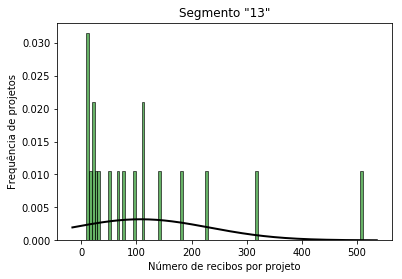

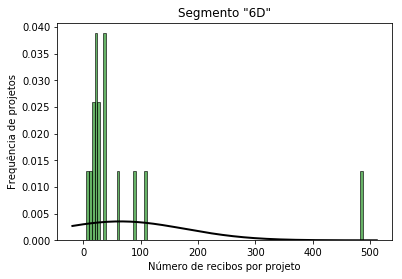

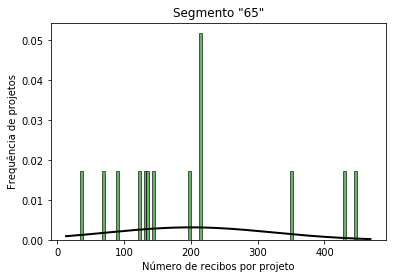

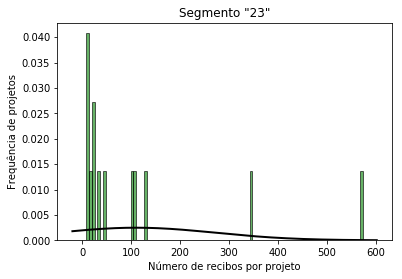

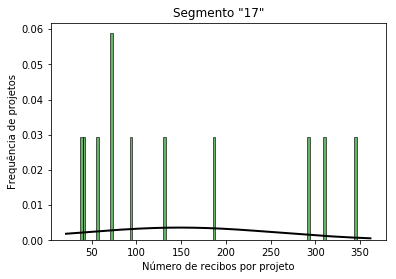

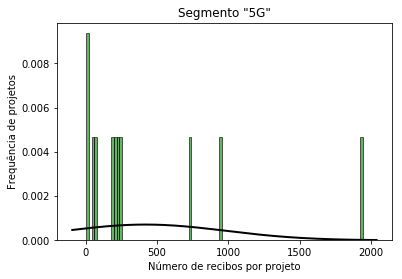

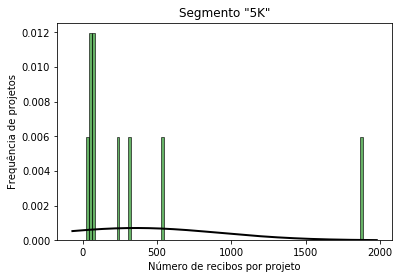

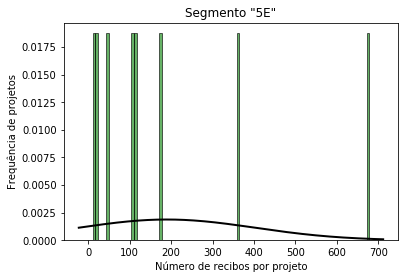

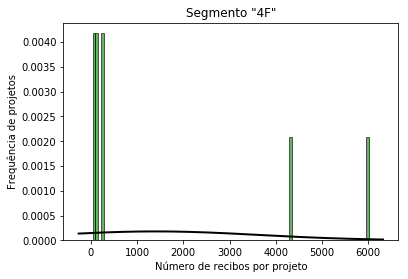

In [90]:
from scipy.stats import norm


def plot_segment(id, receipts):
    plt.hist(receipts, bins=100, density=True, stacked=True, alpha=0.6, color='g', edgecolor='black')
    #plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    plt.title('Segmento "{}"'.format(id))
    plt.xlabel('Número de recibos por projeto')
    plt.ylabel('Frequência de projetos')

    mu, std = np.mean(receipts), np.std(receipts)
    
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 200)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    plt.show()

for counter, id_segmento in enumerate(common_segments.index.values):    
    projects_total_receipts = segment_projects.loc[id_segmento].NumeroComprovantes.values
    plot_segment(id_segmento, projects_total_receipts)
    
    counter += 1
    if counter == 20:
        break

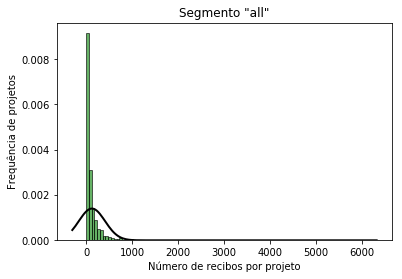

In [91]:
arr = segment_projects['NumeroComprovantes'].values
plot_segment('all', arr)

In [92]:
segment_receipts_avg_std = segment_projects.groupby(['idSegmento'])
segment_receipts_avg_std = segment_receipts_avg_std.agg(['count', 'sum', 'mean', 'std'])

segment_receipts_avg_std.columns = segment_receipts_avg_std.columns.droplevel(0)

display(segment_receipts_avg_std.head())

,count,sum,mean,std
idSegmento,,,,
11,324,40875,126.157407,200.695532
12,149,16328,109.583893,186.223279
13,19,2044,107.578947,128.327409
14,5,211,42.200000,25.013996
17,11,1636,148.727273,115.803360


# Calculando a porcentagem de outliers no conjunto de teste

In [93]:
project_receipts_grp = dt_items[['PRONAC', 'idComprovantePagamento', 'idSegmento']].groupby(['PRONAC'])
project_receipts = project_receipts_grp.nunique()
project_receipts.drop(columns=['PRONAC', 'idSegmento'], inplace=True)
project_receipts.rename(columns={'idComprovantePagamento': 'NumeroComprovantes'}, inplace=True)
display(project_receipts.head())

,NumeroComprovantes
PRONAC,
110023,17
110107,24
110131,34
110152,1
110170,31


In [94]:
id_segmento = '11'
display(segment_receipts_avg_std.loc[id_segmento])
mean = segment_receipts_avg_std.loc[id_segmento]['mean']
print('mean = {}'.format(mean))

count      324.000000
sum      40875.000000
mean       126.157407
std        200.695532
Name: 11, dtype: float64

mean = 126.1574074074074


In [95]:
from salicml.outliers.gaussian_outlier import is_outlier


def is_total_receipts_outlier(pronac):
    assert isinstance(pronac, int)
    
    total_receipts = project_receipts.loc[pronac]['NumeroComprovantes']
    id_segmento = project_receipts_grp.get_group(pronac).iloc[0]['idSegmento']
    
    if not np.isin(id_segmento, segment_receipts_avg_std.index):
        raise ValueError('Segment {} was not trained'.format(id_segmento))
    
    mean = segment_receipts_avg_std.loc[id_segmento]['mean']
    std = segment_receipts_avg_std.loc[id_segmento]['std']
    outlier = is_outlier(total_receipts, mean, std)
    return outlier

pronac = int(np.random.choice(dt_test.PRONAC.values))
print('pronac = {}'.format(pronac))
is_total_receipts_outlier(pronac)

pronac = 1412127


False

In [96]:
from salicml.outliers.gaussian_outlier import outlier_probability


print(outlier_probability(5011203123, 113132, c=1.5))
print(outlier_probability(5, 132, c=1.5))
print(outlier_probability(-1, 3, c=1.5))

0.9331927987311419
0.9331927987311419
0.9331927987311419


In [97]:
pronacs_test = dt_test.PRONAC.unique()

outlier_arr = []

for i, pronac in enumerate(pronacs_test):
    try:
        outlier = is_total_receipts_outlier(int(pronac))
        outlier_arr.append(1.0 if outlier else 0.0)
    except ValueError as err:
        print(err)
    
describe = pd.DataFrame(outlier_arr).describe()
display(describe)

Segment 44 was not trained
Segment 55 was not trained
Segment 59 was not trained
Segment 2B was not trained
Segment 2L was not trained
Segment 4G was not trained
Segment 49 was not trained
Segment 6H was not trained
Segment 2K was not trained
Segment 62 was not trained
Segment 62 was not trained
Segment 49 was not trained
Segment 49 was not trained
Segment 5W was not trained
Segment 5W was not trained


,0
count,1439.000000
mean,0.072272
std,0.259028
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000
